In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima




In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("ARIMA Forecasting") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/05 23:01:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/05 23:01:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/11/05 23:01:04 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/11/05 23:01:04 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
# Load your dataset 
df = spark.read.csv("/Users/sarabjotsingh/Downloads/Feature_engineering.csv", header=True, inferSchema=True)


In [5]:
# Convert date column to timestamp
df = df.withColumn("date", to_timestamp(col("date")))


In [6]:
# Select the 'RSI' column and convert to Pandas for ARIMA modeling
rsi_series = df.select("date", "RSI").toPandas()
rsi_series.set_index('date', inplace=True)
rsi_series['RSI'] = rsi_series['RSI'].astype(float).dropna()

In [7]:
# Define a function to perform the ADF test on a slice of the data
def run_adf_test(data):
    result = adfuller(data)
    return result

In [8]:
# Process the data in chunks (for example, 10000 rows at a time)
chunk_size = 100
num_chunks = int(np.ceil(len(rsi_series) / chunk_size))


In [9]:
# Store results
results = []

In [10]:
for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = start_index + chunk_size
    chunk = rsi_series[start_index:end_index]
    
    # Avoid running ADF on empty chunks
    if len(chunk) > 0:
        result = run_adf_test(chunk)
        results.append(result)

In [11]:
# Print ADF test results for each chunk
for idx, result in enumerate(results):
    print(f"Chunk {idx + 1}:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    

Chunk 1:
ADF Statistic: -2.6165952359765257
p-value: 0.08961564681518097
Chunk 2:
ADF Statistic: -4.774934684306462
p-value: 6.071956358073934e-05
Chunk 3:
ADF Statistic: -3.7908786253648894
p-value: 0.0030020294861074436
Chunk 4:
ADF Statistic: -2.370629618752284
p-value: 0.1501981214931693
Chunk 5:
ADF Statistic: -2.875517513089535
p-value: 0.048269948011425576
Chunk 6:
ADF Statistic: -3.206744808950401
p-value: 0.01959756772501569
Chunk 7:
ADF Statistic: -3.4782666635976915
p-value: 0.008563113425827575
Chunk 8:
ADF Statistic: -3.248243477478977
p-value: 0.017356566501245826
Chunk 9:
ADF Statistic: -2.364530839049063
p-value: 0.1519985210578243
Chunk 10:
ADF Statistic: -2.3954390613717713
p-value: 0.14302784012425768
Chunk 11:
ADF Statistic: -2.8585235003045124
p-value: 0.050388113879812256
Chunk 12:
ADF Statistic: -3.670044226703795
p-value: 0.004554792135324773
Chunk 13:
ADF Statistic: -3.8365153929339
p-value: 0.0025550488035514926
Chunk 14:
ADF Statistic: -3.700227425038749
p-va

In [12]:
# Apply differencing for each chunk if not stationary
if result[1] > 0.05:
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        chunk = rsi_series[start_index:end_index]
        
        # Differencing each chunk
        if len(chunk) > 1:
            differenced_rsi = np.diff(chunk['RSI'].values)  # Apply differencing
            
            # Create a new series and insert NaN for the first value
            differenced_rsi = pd.Series(differenced_rsi, index=chunk.index[1:])
            
            # Update the 'RSI' column with the differenced values, and put NaN for the first value
            chunk['RSI'] = np.concatenate(([np.nan], differenced_rsi.values))  # Add NaN for the first element
            
            rsi_series[start_index:end_index] = chunk  # Replace the chunk in the main dataframe

/var/folders/h_/kssb81453xb2cjn36fxdy_z40000gn/T/ipykernel_70472/1964272705.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['RSI'] = np.concatenate(([np.nan], differenced_rsi.values))  # Add NaN for the first element


In [13]:
# Use auto_arima to find the best parameters with reduced search space and parallel processing
stepwise_model = auto_arima(rsi_series['RSI'].dropna(), 
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,  # Reduce max_p and max_q
                             m=1, 
                             start_P=0, 
                             seasonal=False,
                             d=1, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True,
                             n_jobs=-1)  # Use all CPU cores for faster computation


/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=106.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4056689.755, Time=2.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3898937.348, Time=3.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=57.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4056687.755, Time=1.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3840299.668, Time=4.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3801254.621, Time=5.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=159.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=183.65 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3801252.621, Time=2.57 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3840297.668, Time=2.24 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=70.58 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=46.00 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 645.754 seconds


In [14]:
# Print the best ARIMA model found
print(f"Best ARIMA model: {stepwise_model.order}")

Best ARIMA model: (3, 1, 0)


In [15]:
# Fit the best ARIMA model
model = ARIMA(rsi_series['RSI'].dropna(), order=stepwise_model.order)
model_fit = model.fit()

/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting

In [16]:
# Print summary of the optimized model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    RSI   No. Observations:               450602
Model:                 ARIMA(3, 1, 0)   Log Likelihood            -1900622.310
Date:                Tue, 05 Nov 2024   AIC                        3801252.621
Time:                        23:12:08   BIC                        3801296.694
Sample:                             0   HQIC                       3801265.152
                             - 450602                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8340      0.001   -856.859      0.000      -0.836      -0.832
ar.L2         -0.5606      0.001   -450.701      0.000      -0.563      -0.558
ar.L3         -0.2881      0.001   -258.723      0.0

In [17]:
# Forecast 10 steps ahead
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
print("Forecasted RSI values:\n", forecast)


Forecasted RSI values:
 450602   -8.017639
450603   -5.704851
450604   -7.479434
450605   -5.515365
450606   -6.824871
450607   -6.322552
450608   -6.573231
450609   -6.268489
450610   -6.526831
450611   -6.409994
Name: predicted_mean, dtype: float64


/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


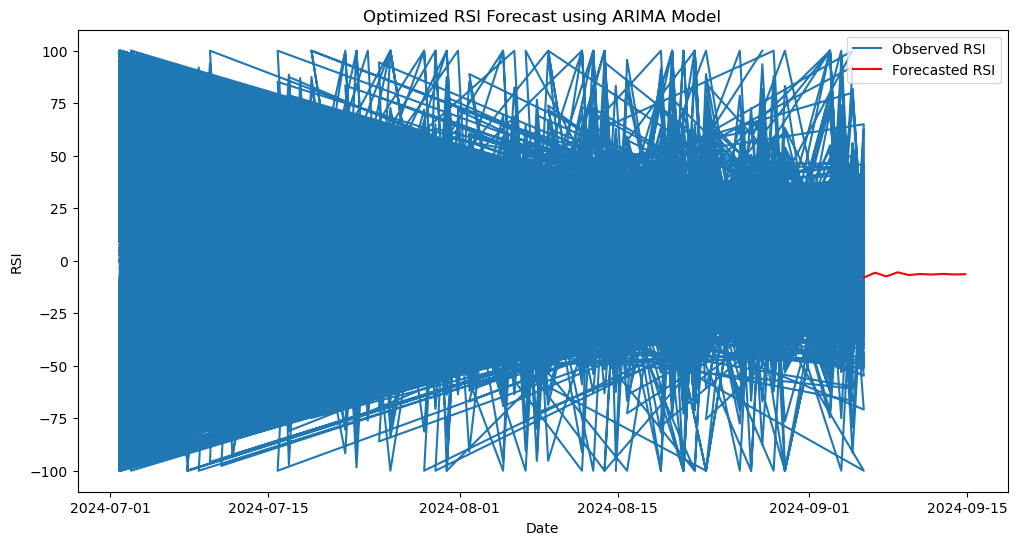

In [18]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(rsi_series.index, rsi_series['RSI'], label='Observed RSI')
plt.plot(pd.date_range(rsi_series.index[-1], periods=forecast_steps, freq='D'), forecast, label='Forecasted RSI', color='red')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Optimized RSI Forecast using ARIMA Model')
plt.legend()
plt.show()


/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting

                               SARIMAX Results                                
Dep. Variable:                    RSI   No. Observations:               450602
Model:                 ARIMA(3, 1, 0)   Log Likelihood            -1900622.310
Date:                Tue, 05 Nov 2024   AIC                        3801252.621
Time:                        23:13:34   BIC                        3801296.694
Sample:                             0   HQIC                       3801265.152
                             - 450602                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8340      0.001   -856.859      0.000      -0.836      -0.832
ar.L2         -0.5606      0.001   -450.701      0.000      -0.563      -0.558
ar.L3         -0.2881      0.001   -258.723      0.0

/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sarabjotsingh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecasted RSI values:
 450602   -8.017639
450603   -5.704851
450604   -7.479434
450605   -5.515365
450606   -6.824871
450607   -6.322552
450608   -6.573231
450609   -6.268489
450610   -6.526831
450611   -6.409994
Name: predicted_mean, dtype: float64


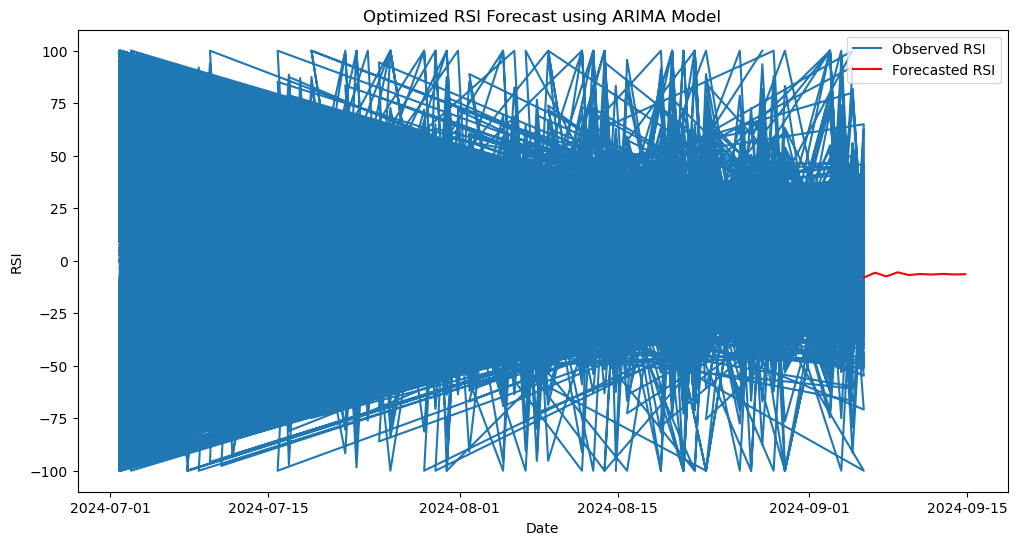

24/11/06 02:28:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 973578 ms exceeds timeout 120000 ms
24/11/06 02:28:09 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/06 02:28:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
import joblib

# Fit the best ARIMA model
model = ARIMA(rsi_series['RSI'].dropna(), order=stepwise_model.order)
model_fit = model.fit()

# Print summary of the optimized model
print(model_fit.summary())

# Save the trained ARIMA model using joblib
joblib.dump(model_fit, '/Users/sarabjotsingh/Downloads/arima_model.pkl')

# Forecast 10 steps ahead
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
print("Forecasted RSI values:\n", forecast)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(rsi_series.index, rsi_series['RSI'], label='Observed RSI')
plt.plot(pd.date_range(rsi_series.index[-1], periods=forecast_steps, freq='D'), forecast, label='Forecasted RSI', color='red')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Optimized RSI Forecast using ARIMA Model')
plt.legend()
plt.show()